In [2]:
!pip install yfinance
!pip install tf-keras
!pip install --upgrade transformers

Device set to use mps:0


Fetching Apple stock data...


[*********************100%***********************]  1 of 1 completed


Fetching financial news...
Processing data...
Building and training the model...
Epoch 1/10
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - loss: 0.6361 - mae: 0.7498
Epoch 2/10
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.0865 - mae: 0.2466
Epoch 3/10
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.0743 - mae: 0.1995
Epoch 4/10
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0568 - mae: 0.1916
Epoch 5/10
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.1017 - mae: 0.2760
Epoch 6/10
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.0547 - mae: 0.1780
Epoch 7/10
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.0577 - mae: 0.1931
Epoch 8/10
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.0607 - mae: 0.2148
Epoch 9/10
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0705 - mae: 0.2125
Epoch 10/10
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0440 - mae: 0.1842
Making predictions...
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 107ms/step
Root Mean Squared Error (RMSE): 0.17
Mean Absolute Error (MAE): 0.15


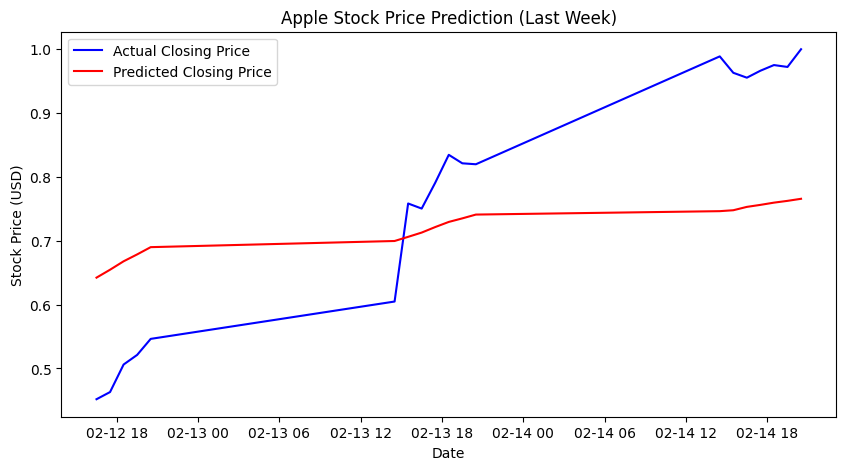

In [1]:
import yfinance as yf
import numpy as np
import pandas as pd
import requests
import matplotlib.pyplot as plt
from transformers import pipeline
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv1D, LSTM, Dense, Dropout, LayerNormalization, MultiHeadAttention
from sklearn.metrics import mean_squared_error, mean_absolute_error

# --------------------- FETCH STOCK DATA ---------------------
def fetch_stock_data(ticker, period="7d", interval="1h"):
    stock = yf.download(ticker, period=period, interval=interval)
    return stock[['Open', 'High', 'Low', 'Close', 'Volume']]

# --------------------- FETCH FINANCIAL NEWS ---------------------
ALPHA_VANTAGE_API_KEY = "YZLER8J5MQIQA0FY"

def fetch_financial_news():
    url = f"https://www.alphavantage.co/query?function=NEWS_SENTIMENT&tickers=AAPL&apikey={ALPHA_VANTAGE_API_KEY}"
    response = requests.get(url).json()

    # Check if 'feed' is in the response
    if 'feed' in response:
        # If 'feed' exists, attempt to extract the headlines
        headlines = [article.get("headline", "No headline available") for article in response["feed"][:10]]
        return headlines
    else:
        # If 'feed' does not exist, print the response for debugging
        print("Error: 'feed' key not found in response.")
        print(response)
        return []  # Return an empty list in case of error

# --------------------- SENTIMENT ANALYSIS ---------------------
sentiment_model = pipeline("text-classification", model="ProsusAI/finbert")

def analyze_sentiment(texts):
    results = sentiment_model(texts, truncation=True, max_length=512)
    return [1 if res['label'] == 'positive' else (-1 if res['label'] == 'negative' else 0) for res in results]

# --------------------- DATA PREPROCESSING ---------------------
def preprocess_data(stock_df, sentiment_scores):
    stock_df["Sentiment"] = np.random.choice(sentiment_scores, size=len(stock_df))  # Simulate sentiment scores
    stock_df.dropna(inplace=True)
    return stock_df

# --------------------- SEQUENCE CREATION ---------------------
def create_sequences(data, seq_length=30):
    sequences, labels = [], []
    for i in range(len(data) - seq_length):
        sequences.append(data[i:i+seq_length])
        labels.append(data[i+seq_length, 3])  # Predicting the closing price
    return np.array(sequences), np.array(labels)

# --------------------- BUILD CNN + TRANSFORMER MODEL ---------------------
def create_hybrid_model(seq_length, feature_dim):
    inputs = Input(shape=(seq_length, feature_dim))

    # CNN Layer
    x = Conv1D(filters=128, kernel_size=5, activation="relu", padding="same")(inputs)
    x = Conv1D(filters=64, kernel_size=3, activation="relu", padding="same")(x)

    # Transformer Layer
    attn_output = MultiHeadAttention(num_heads=8, key_dim=feature_dim)(x, x)
    x = LayerNormalization()(attn_output + x)

    # LSTM Layer
    x = LSTM(64, return_sequences=True)(x)
    x = LSTM(32)(x)

    # Fully Connected Layers
    x = Dense(64, activation="relu")(x)
    x = Dropout(0.3)(x)
    outputs = Dense(1, activation="linear")(x)

    model = Model(inputs, outputs)
    model.compile(optimizer="adam", loss="mse", metrics=["mae"])
    return model

# --------------------- MAIN EXECUTION ---------------------
if __name__ == "__main__":
    # Fetch last week's Apple stock data
    print("Fetching Apple stock data...")
    stock_data = fetch_stock_data("AAPL")
    
    # Fetch financial news and analyze sentiment
    print("Fetching financial news...")
    news_headlines = fetch_financial_news()
    sentiment_scores = analyze_sentiment(news_headlines)
    
    # Merge sentiment data into stock dataset
    print("Processing data...")
    processed_data = preprocess_data(stock_data, sentiment_scores)

    # Normalize data
    scaler = MinMaxScaler()
    scaled_features = scaler.fit_transform(processed_data)

    # Create sequences
    seq_length = 30
    X_test, y_test = create_sequences(scaled_features, seq_length)
    
    # Load pre-trained model or train a new one
    print("Building and training the model...")
    model = create_hybrid_model(seq_length, X_test.shape[2])
    model.fit(X_test, y_test, epochs=10, batch_size=16, verbose=1)

    # Predict stock prices
    print("Making predictions...")
    predictions = model.predict(X_test)
    
    # Convert predictions back to original scale
    # Create an array with the same number of columns as the original data (5 in this case)

    scaled_predictions = np.column_stack((np.zeros((len(predictions), 5)), predictions))
    
    # Now inverse transform using the scaler
    predicted_prices = scaler.inverse_transform(scaled_predictions)[:, 5]  # Take the last column as predicted price

    # Compute accuracy metrics
    rmse = np.sqrt(mean_squared_error(y_test, predicted_prices))
    mae = mean_absolute_error(y_test, predicted_prices)

    print(f"Root Mean Squared Error (RMSE): {rmse:.2f}")
    print(f"Mean Absolute Error (MAE): {mae:.2f}")

    # Plot actual vs predicted prices
    plt.figure(figsize=(10, 5))
    plt.plot(processed_data.index[seq_length:], y_test, label="Actual Closing Price", color="blue")
    plt.plot(processed_data.index[seq_length:], predicted_prices, label="Predicted Closing Price", color="red")
    plt.legend()
    plt.title("Apple Stock Price Prediction (Last Week)")
    plt.xlabel("Date")
    plt.ylabel("Stock Price (USD)")
    plt.show()


In [2]:
import yfinance as yf
import numpy as np
import pandas as pd
import requests
import matplotlib.pyplot as plt
from transformers import pipeline
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv1D, LSTM, Dense, Dropout, LayerNormalization, MultiHeadAttention
from sklearn.metrics import mean_squared_error, mean_absolute_error

# --------------------- FETCH STOCK DATA ---------------------
def fetch_stock_data(ticker, period="7d", interval="1h"):
    stock = yf.download(ticker, period=period, interval=interval)
    return stock[['Open', 'High', 'Low', 'Close', 'Volume']]

# --------------------- FETCH FINANCIAL NEWS ---------------------
ALPHA_VANTAGE_API_KEY = "YZLER8J5MQIQA0FY"

def fetch_financial_news():
    url = f"https://www.alphavantage.co/query?function=NEWS_SENTIMENT&tickers=AAPL&apikey={ALPHA_VANTAGE_API_KEY}"
    response = requests.get(url).json()

    # Check if 'feed' is in the response
    if 'feed' in response:
        headlines = [article.get("headline", "No headline available") for article in response["feed"][:10]]
        return headlines
    else:
        print("Error: 'feed' key not found in response.")
        print(response)
        return []

# --------------------- SENTIMENT ANALYSIS ---------------------
sentiment_model = pipeline("text-classification", model="ProsusAI/finbert")

def analyze_sentiment(texts):
    results = sentiment_model(texts, truncation=True, max_length=512)
    return [1 if res['label'] == 'positive' else (-1 if res['label'] == 'negative' else 0) for res in results]

# --------------------- DATA PREPROCESSING ---------------------
def preprocess_data(stock_df, sentiment_scores):
    stock_df["Sentiment"] = np.random.choice(sentiment_scores, size=len(stock_df))  # Simulate sentiment scores
    stock_df.dropna(inplace=True)
    return stock_df

# --------------------- SEQUENCE CREATION ---------------------
def create_sequences(data, seq_length=30):
    sequences, labels = [], []
    for i in range(len(data) - seq_length):
        sequences.append(data[i:i+seq_length])
        labels.append(data[i+seq_length, 3])  # Predicting the closing price
    return np.array(sequences), np.array(labels)

# --------------------- BUILD CNN + TRANSFORMER MODEL ---------------------
def create_hybrid_model(seq_length, feature_dim):
    inputs = Input(shape=(seq_length, feature_dim))

    # CNN Layer
    x = Conv1D(filters=128, kernel_size=5, activation="relu", padding="same")(inputs)
    x = Conv1D(filters=64, kernel_size=3, activation="relu", padding="same")(x)

    # Transformer Layer
    attn_output = MultiHeadAttention(num_heads=8, key_dim=feature_dim)(x, x)
    x = LayerNormalization()(attn_output + x)

    # LSTM Layer
    x = LSTM(64, return_sequences=True)(x)
    x = LSTM(32)(x)

    # Fully Connected Layers
    x = Dense(64, activation="relu")(x)
    x = Dropout(0.3)(x)
    outputs = Dense(1, activation="linear")(x)

    model = Model(inputs, outputs)
    model.compile(optimizer="adam", loss="mse", metrics=["mae"])
    return model

# --------------------- MAIN EXECUTION ---------------------
if __name__ == "__main__":
    # Fetch last week's Apple stock data
    print("Fetching Apple stock data...")
    stock_data = fetch_stock_data("AAPL")
    
    # Fetch financial news and analyze sentiment
    print("Fetching financial news...")
    news_headlines = fetch_financial_news()
    sentiment_scores = analyze_sentiment(news_headlines)
    
    # Merge sentiment data into stock dataset
    print("Processing data...")
    processed_data = preprocess_data(stock_data, sentiment_scores)

    # Normalize data
    scaler = MinMaxScaler()
    scaled_features = scaler.fit_transform(processed_data)

    # Create sequences for training
    seq_length = 30
    X_train, y_train = create_sequences(scaled_features, seq_length)

    # Load pre-trained model or train a new one
    print("Building and training the model...")
    model = create_hybrid_model(seq_length, X_train.shape[2])
    model.fit(X_train, y_train, epochs=10, batch_size=16, verbose=1)

    # Test the model on the last sequence (next day's price)
    print("Testing model on the last sequence...")
    last_sequence = X_train[-1:]  # Use the last sequence from the training data
    true_value = y_train[-1]  # True value (closing price for the last sequence)

    # Predict the next day's price
    predicted_value = model.predict(last_sequence)[0][0]  # Prediction for the last sequence

    # Create an array with the correct number of columns (matching training data)
    scaled_predictions = np.zeros((1, scaled_features.shape[1]))  # Same number of columns as training data
    scaled_predictions[:, 3] = predicted_value  # Put prediction in the 'Close' price column

    # Now inverse transform using the scaler
    predicted_price = scaler.inverse_transform(scaled_predictions)[:, 3][0]  # Extract the 'Close' column

    # Get the actual true price from scaled data
    true_price_scaled = np.zeros((1, scaled_features.shape[1]))
    true_price_scaled[:, 3] = true_value  # Insert actual value in 'Close' column
    true_price = scaler.inverse_transform(true_price_scaled)[:, 3][0]  # Extract the 'Close' column

    # Print results
    print(f"Predicted Price: {predicted_price:.2f}")
    print(f"True Price: {true_price:.2f}")


Device set to use mps:0


Fetching Apple stock data...


[*********************100%***********************]  1 of 1 completed

1 Failed download:
['AAPL']: YFRateLimitError('Too Many Requests. Rate limited. Try after a while.')


Fetching financial news...
Processing data...


ValueError: Found array with 0 sample(s) (shape=(0, 6)) while a minimum of 1 is required by MinMaxScaler.

In [3]:
import yfinance as yf
import numpy as np
import pandas as pd
import requests
import matplotlib.pyplot as plt
from transformers import pipeline
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv1D, LSTM, Dense, Dropout, LayerNormalization, MultiHeadAttention
from sklearn.metrics import mean_squared_error, mean_absolute_error

# --------------------- FETCH STOCK DATA ---------------------
def fetch_stock_data(ticker, period="7d", interval="1h"):
    stock = yf.download(ticker, period=period, interval=interval)
    return stock[['Open', 'High', 'Low', 'Close', 'Volume']]

# --------------------- FETCH FINANCIAL STATEMENTS ---------------------
def fetch_financial_statements(ticker):
    stock = yf.Ticker(ticker)
    income_stmt = stock.financials.T  # Income Statement
    balance_sheet = stock.balance_sheet.T  # Balance Sheet
    cash_flow = stock.cashflow.T  # Cash Flow Statement
    
    # Selecting relevant features (e.g., Revenue, Net Income, Total Assets, Cash Flow from Operations)
    financials = pd.concat([
        income_stmt[['Total Revenue', 'Net Income']],
        balance_sheet[['Total Assets', 'Total Liabilities']],
        cash_flow[['Operating Cash Flow']]
    ], axis=1)
    
    financials.fillna(0, inplace=True)  # Handle missing values
    return financials

# --------------------- FETCH FINANCIAL NEWS ---------------------
ALPHA_VANTAGE_API_KEY = "YZLER8J5MQIQA0FY"

def fetch_financial_news():
    url = f"https://www.alphavantage.co/query?function=NEWS_SENTIMENT&tickers=AAPL&apikey={ALPHA_VANTAGE_API_KEY}"
    response = requests.get(url).json()
    if 'feed' in response:
        headlines = [article.get("headline", "No headline available") for article in response["feed"][:10]]
        return headlines
    else:
        print("Error: 'feed' key not found in response.")
        return []

# --------------------- SENTIMENT ANALYSIS ---------------------
sentiment_model = pipeline("text-classification", model="ProsusAI/finbert")

def analyze_sentiment(texts):
    results = sentiment_model(texts, truncation=True, max_length=512)
    return [1 if res['label'] == 'positive' else (-1 if res['label'] == 'negative' else 0) for res in results]

# --------------------- DATA PREPROCESSING ---------------------
def preprocess_data(stock_df, sentiment_scores, financial_data):
    stock_df["Sentiment"] = np.random.choice(sentiment_scores, size=len(stock_df))
    
    # Merge financial data by aligning dates
    financial_data = financial_data.reindex(stock_df.index, method='ffill')
    stock_df = pd.concat([stock_df, financial_data], axis=1)
    stock_df.dropna(inplace=True)
    return stock_df

# --------------------- SEQUENCE CREATION ---------------------
def create_sequences(data, seq_length=30):
    sequences, labels = [], []
    for i in range(len(data) - seq_length):
        sequences.append(data[i:i+seq_length])
        labels.append(data[i+seq_length, 3])  # Predicting the closing price
    return np.array(sequences), np.array(labels)

# --------------------- BUILD CNN + TRANSFORMER MODEL ---------------------
def create_hybrid_model(seq_length, feature_dim):
    inputs = Input(shape=(seq_length, feature_dim))
    x = Conv1D(filters=128, kernel_size=5, activation="relu", padding="same")(inputs)
    x = Conv1D(filters=64, kernel_size=3, activation="relu", padding="same")(x)
    attn_output = MultiHeadAttention(num_heads=8, key_dim=feature_dim)(x, x)
    x = LayerNormalization()(attn_output + x)
    x = LSTM(64, return_sequences=True)(x)
    x = LSTM(32)(x)
    x = Dense(64, activation="relu")(x)
    x = Dropout(0.3)(x)
    outputs = Dense(1, activation="linear")(x)
    model = Model(inputs, outputs)
    model.compile(optimizer="adam", loss="mse", metrics=["mae"])
    return model

# --------------------- MAIN EXECUTION ---------------------
if __name__ == "__main__":
    print("Fetching Apple stock data...")
    stock_data = fetch_stock_data("AAPL")
    
    print("Fetching financial statements...")
    financial_statements = fetch_financial_statements("AAPL")
    
    print("Fetching financial news...")
    news_headlines = fetch_financial_news()
    sentiment_scores = analyze_sentiment(news_headlines)
    
    print("Processing data...")
    processed_data = preprocess_data(stock_data, sentiment_scores, financial_statements)
    
    scaler = MinMaxScaler()
    scaled_features = scaler.fit_transform(processed_data)
    
    seq_length = 30
    X_train, y_train = create_sequences(scaled_features, seq_length)
    
    print("Building and training the model...")
    model = create_hybrid_model(seq_length, X_train.shape[2])
    model.fit(X_train, y_train, epochs=10, batch_size=16, verbose=1)
    
    print("Testing model on the last sequence...")
    last_sequence = X_train[-1:]
    true_value = y_train[-1]
    predicted_value = model.predict(last_sequence)[0][0]
    
    scaled_predictions = np.zeros((1, scaled_features.shape[1]))
    scaled_predictions[:, 3] = predicted_value
    predicted_price = scaler.inverse_transform(scaled_predictions)[:, 3][0]
    
    true_price_scaled = np.zeros((1, scaled_features.shape[1]))
    true_price_scaled[:, 3] = true_value
    true_price = scaler.inverse_transform(true_price_scaled)[:, 3][0]
    
    print(f"Predicted Price: {predicted_price:.2f}")
    print(f"True Price: {true_price:.2f}")


Device set to use mps:0


Fetching Apple stock data...


[*********************100%***********************]  1 of 1 completed

1 Failed download:
['AAPL']: YFRateLimitError('Too Many Requests. Rate limited. Try after a while.')


Fetching financial statements...


KeyError: "None of [Index(['Total Revenue', 'Net Income'], dtype='object')] are in the [columns]"